# Document deduplication using Locality Sensitive Hashing (LSH) with minhash

This notebook gives an overview of locality sensitive hashing for the purpose of deduplicating large collections of documents. The associated code is available from https://github.com/mattilyra/lsh.

Finding exact duplicates is trivially easy (just use `md5`) but finding near duplicates is much harder. Many document collections from tweets to news text to forum discussions contain documents that are almost exactly the same, with only a few sentences or characters that differ. A hash function such as `md5` won't find these near duplicates as they are not the same on the byte level, but rather on the semantic level. Finding these semantic duplicates can be done, for instance, by using n-gram shingles and computing the Jaccard similarity of the shingle sets. This is computationally very expensive as the similarity between all pairs of documents needs to be computed. The <cite>Reuters Corpus Version 1.0 (RCV1)</cite> [1] is ~810k documents, that's $810000^2 = 656100000000$ comparisons, assuming the we have a really fast computer that can generate a pair of shingles and compute their Jaccard similarity in 1 microsecond, that still takes a bit over a week to go through all of them, luckily the similarities are symmetric so going through half of $656100000000$ is enough, that is still ~3 days. The <cite>Amazon Product Data</cite> [2] is what could be called webscale ~140 million product reviews. I don't even want to think about how long that would take.

Locality senstive hashing (LSH) relies on two different methods, first a hash fingerprint of each document is created and then the locality sensitive hashing is applied to that fingerprint. If the fingerprint is generated using the `minhash` algorithm then the probability of a hash collision is equal to the Jaccard distance of the documents. There are other hash functions that correspond to the cosine similarity for instance, but I won't deal with those here.

## Document similarity and minhash

Minhash is a hash function that computes the lowest hash value for a set of objects to be hashes. In the case of comparing document similarities the set of objects is word or character ngrams taken over a sliding window from the document - also known as shingles. The set of shingles allows us to compute the document similarity (defined in this case as Jaccard similarity) between a pair of documents.

#### For instance:

In [1]:
document = 'Lorem Ipsum dolor sit amet'
# shingle and discard the last 5 as these are just the last n<5 characters from the document
shingles = [document[i:i+5] for i in range(len(document))][:-5]
shingles

['Lorem',
 'orem ',
 'rem I',
 'em Ip',
 'm Ips',
 ' Ipsu',
 'Ipsum',
 'psum ',
 'sum d',
 'um do',
 'm dol',
 ' dolo',
 'dolor',
 'olor ',
 'lor s',
 'or si',
 'r sit',
 ' sit ',
 'sit a',
 'it am',
 't ame']

In [2]:
other_document = 'Lorem Ipsum dolor sit amet is how dummy text starts'
# shingle and discard the last 5 as these are just the last n<5 characters from the document
other_shingles = [other_document[i:i+5] for i in range(len(other_document))][:-5]

# Jaccard distance is the size of set intersection divided by the size of set union
len(set(shingles) & set(other_shingles)) / len(set(shingles) | set(other_shingles))

0.45652173913043476

As we can see these two documents are not very similar, at least in terms of their 3-gram shingle Jaccard similarity. That aside the problem with these shingles is that they do not allow us to compute the similarities of large numbers of documents very easily, we have to do an all pairs comparison. To get around that we can use locality sensitive hashing, but before LSH we'll turn the documents into a more manageable and uniform representation: a fixed length _fingerprint_ comprised of $k$ `minhash`es.

Every document has a different number of shingles depending on the length of the document, for a corpus of any size predicting the memory requirements for an all pairs comparison is not possible as each document will consume a variable amount of memory. For LSH we would like to have a fixed length representation of the documents without changing the semantics of document similarity. This is where `minhash`ing comes in. It turns out that the probability of a hash collision for a `minhash` is exactly the Jaccard similarity of two sets. This can be seen by considering the two sets of shingles as a matrix. For two dummy documents the shingles could be represented as the table below (the zeros and ones indicate if a shingle is present in the document or not). Notice that the Jaccard similarity of the documents is `2/5`.

<table>
<th colspan=4><center>Document Shingles</center></th>
<tr> <td>row</td><td>shingle ID</td><td>Doc 1</td><td>Doc 2</td> </tr>
<tr> <td>1</td><td>1</td><td>0</td><td>1</td> </tr>
<tr> <td>2</td><td>2</td><td>1</td><td>1</td> </tr>
<tr> <td>3</td><td>3</td><td>0</td><td>1</td> </tr>
<tr> <td>4</td><td>4</td><td>1</td><td>0</td> </tr>
<tr> <td>5</td><td>5</td><td>1</td><td>1</td> </tr>
<tr> <td>6</td><td>6</td><td>0</td><td>0</td> </tr>
</table>

The `minhash` corresponds to a random permutation of the rows and gives back the row number where the first non zero entry is found. For the above table the `minhash` for documents one and two would thus be `2` and `1` respectively - meaning that the documents are not similar. The above table however is just one ordering of the shingles of each document. A different random permutation of the rows will give a different `minhash`, in this case `2` and `2`, making the documents similar.

<table>
<th colspan=4><center>Document Shingles</center></th>
<tr> <td>row</td><td>shingle ID</td><td>Doc 1</td><td>Doc 2</td> </tr>
<tr> <td>1</td><td>6</td><td>0</td><td>0</td> </tr>
<tr> <td>2</td><td>2</td><td>1</td><td>1</td> </tr>
<tr> <td>3</td><td>3</td><td>0</td><td>1</td> </tr>
<tr> <td>4</td><td>1</td><td>0</td><td>1</td> </tr>
<tr> <td>5</td><td>4</td><td>1</td><td>0</td> </tr>
<tr> <td>6</td><td>5</td><td>1</td><td>1</td> </tr>
</table>

A random permutation of the rows can produce any of `6! == 720` ([factorial](https://en.wikipedia.org/wiki/Factorial)) different orderings. However we only care about the orderings for which the two columns have the same lowest row number with a 1, that is `shingle ID` $\in \{2, 5\}$. Since the rows with zeros on them don't count, there are 5 rows with a one on it in any column, and two rows with a 1 in both columns. All a random permutation can therefore do is put two out of the five rows in the lowest row number, in other words produce a hash collision with a probability `2/5`.

The above explanation follows Chapter 3 of <cite>Mining Massive Datasets</cite> [3]. An in depth explanation for why and how `minhash` works is provided there along with other interesting hash functions.

Applying `minhash` gives us a fixed length $k$ (you pick the length) representation of each document such that the probability of a hash collision is equal to the Jaccard similarity of any pair. This being a probabilitic measure you're not guaranteed to get a collision. For Lorem Ipsum documents above and $k=100$ we get similarities that are roughly the same as the Jaccard similarity.

In [3]:
from lsh import minhash

for _ in range(5):
    hasher = minhash.MinHasher(seeds=100, char_ngram=5)
    fingerprint0 = hasher.fingerprint('Lorem Ipsum dolor sit amet'.encode('utf8'))
    fingerprint1 = hasher.fingerprint('Lorem Ipsum dolor sit amet is how dummy text starts'.encode('utf8'))
    print(sum(fingerprint0[i] in fingerprint1 for i in range(hasher.num_seeds)) / hasher.num_seeds)

0.5
0.4
0.45
0.46
0.47


Increasing the length of the fingerprint from $k=100$ to $k=1000$ reduces the variance between random initialisations of the `minhash`er.

In [4]:
for _ in range(5):
    hasher = minhash.MinHasher(seeds=1000, char_ngram=5)
    fingerprint0 = hasher.fingerprint('Lorem Ipsum dolor sit amet'.encode('utf8'))
    fingerprint1 = hasher.fingerprint('Lorem Ipsum dolor sit amet is how dummy text starts'.encode('utf8'))
    print(sum(fingerprint0[i] in fingerprint1 for i in range(hasher.num_seeds)) / hasher.num_seeds)

0.464
0.412
0.477
0.484
0.483


Increasing the fingerprint length however comes at the cost of increased memory usage and more time spent computing the `minhash`es. For a collection of documents we are still left with comparing all pairs, when that collection grows larger this becomes a very real problem. Queue LSH.

## Locality sensitive hashing

The idea behind locality sensitive hashing is to take the document fingerprints and chop them up into pieces, each piece being some number of `minhash`es. Since a single `minhash` (single entry in the fingerprint) has a probability equal to the Jaccard similarity of producing a collision, each chopped up portion of the fingerprint should as well. This chopped up portion is the `locality` in locality sensitive hashing, the `hashing` is just a hash function (any hash function) which produces a `bin ID` from the fingerprint `locality` being hashed. Each bin holds the entire fingerprint (with optional meta information) of the document and that of other documents that hash to the same `bin`.

Let's say our fingerprint has 100 `minhash`es in it and we chop the fingerprints into 10 pieces. Each piece of each fingerprint therefore contains 10 `minhash`es, we hash those again (not using `minhash` this time) to get a `bin ID` and store the whole fingerprint in every bin each of the pieces happens to land in.

When we want to know which documents are similar to a query document, we look in all the bins the query document lands in, any document in any of the bins is a potential duplicate. Comparing the full fingerprint of all documents in the bin or computing the actual Jaccard similarity between the shingle sets yields the final similarity of documents. Crucially _since not all documents will land in the same bins we've reduced the number of comparisons needed to find similar or near duplicate documents_.

The number of pieces to chop each fingerprint into and the size of each piece are parameters that need to be set. These should be set such that $num\_pieces \times size\_of\_piece == num\_minhashes$ - this makes sense since having computed all the $N$ `minhash`es we want to use all of them in the locality sensitive hashing part. There is however a further issue that needs to be considered when setting the parameters; the relation between the number and size of the pieces and the probability of LSH "finding" a pair of similar documents.

LSH is a probabilistic model which means that it won't always do the "right thing". Using LSH one needs to consider the similarity of a pair of documents (in this case the Jaccard similarity) and the probability that LSH will find that pair to be similar (a true positive, i.e. a correctly discovered duplicate pair). The pair of documents LSH finds to be similar should be thought of as _candidate_ duplicates. The higher the probability, or guarantee, that LSH will find a pair of documents to be similar the more false positives the model will also produce, that is candidate duplicates that are not in fact duplicates.

In [6]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

ix = pd.IndexSlice

/home/matti/miniconda3/envs/lsh/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### <a id='bands_rows'>How setting LSH parameters affects finding similar documents</a>

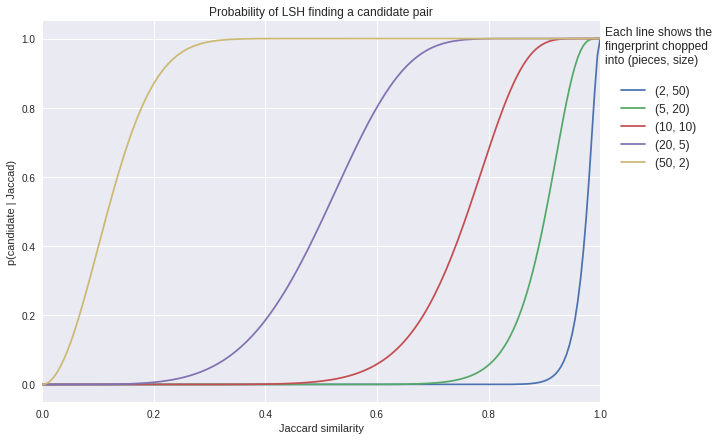

In [7]:
df = pd.DataFrame(data=[(2, 50), (50, 2), (10, 10), (5, 20), (20, 5)], columns=['pieces', 'size'])
df['hashes'] = df['pieces'] * df['size']
for pr in np.linspace(0, 1, 200):
    df[pr] = 1 - (1 - pr**df['size']) ** df['pieces']

df = pd.pivot_table(df, index=['hashes', 'pieces', 'size'])

ax = df.T.plot(figsize=(10, 7), title='Probability of LSH finding a candidate pair');
plt.ylabel('p(candidate | Jaccad)');
plt.xlabel('Jaccard similarity');
plt.legend(list(df.loc[ix[100]].index),
           bbox_to_anchor=(1., 1, 1., 0), loc='upper left', fontsize=12, 
           ncol=1, borderaxespad=0., title='Each line shows the\nfingerprint chopped\ninto (pieces, size)\n');

The figure shows the probability that LSH with `minhash` will "find" a pair of similar documents (`y-axis`) given the Jaccard similarity (`x-axis`) of those documents for different settings for LSH. Each of the five lines correspond to different settings, the number of hashes is always 100 so we're just changing the number of pieces to chop each fingerprint into (and the size of those pieces, although that becomes determined by setting the number of hashes).

Creating just two pieces with 50 rows each - that is two localities, each with a size of 50 `minhash`es - yields an LSH model (<font color=#4C72B0>blue line</font>) that tries really really hard not to find documents to be similar. This LSH model will find 80% of documents whose actual Jaccard similarity is over 95%. Documents whose Jaccard similarity is 80% will hardly ever be found to be similar.

Creating 5 pieces with 20 rows (<font color=#55A868>green line</font>) each is slightly more relaxed. The above graph should give you a pretty good idea how to set the parameters for your use case so that you can be reasonably certain that LSH will generate acceptable candidate pairs.

-----------

## Deduplicating the Reuters RCV1 corpus [1]

The Reuters Corpus, Volume 1 (RCV1) corpus is a commonly used resource for various NLP tasks, especially document classification. It was made available in 2000 by Reuters Ltd and consists of ~810,000 english language news stories collected between August 20th 1996 and August 19th 1997 from the Reuters news wire.

I've preprocessed the corpus so that it is all in a single file, one line per document. Each line has the format:

    ITEMID<TAB>HEADLINE<SPACE>TEXT

In [94]:
!wc -l ../data/rcv1/headline.text.txt

  806791 ../data/rcv1/headline.text.txt


In [123]:
!head -1 ../data/rcv1/headline.text.txt

2286	Recovery excitement brings Mexican markets to life.  Emerging evidence that Mexico's economy was back on the recovery track sent Mexican markets into a buzz of excitement Tuesday, with stocks closing at record highs and interest rates at 19-month lows. "Mexico has been trying to stage a recovery since the beginning of this year and it's always been getting ahead of itself in terms of fundamentals," said Matthew Hickman of Lehman Brothers in New York. "Now we're at the point where the fundamentals are with us. The history is now falling out of view." That history is one etched into the minds of all investors in Mexico: an economy in crisis since December 1994, a free-falling peso and stubbornly high interest rates. This week, however, second-quarter gross domestic product was reported up 7.2 percent, much stronger than most analysts had expected. Interest rates on governent Treasury bills, or Cetes, in the secondary market fell on Tuesday to 23.90 percent, their lowest level since 

Some duplicate items are present in the corpus so let's see what happens when we apply LSH to it. First a helper function that takes a file pointer and some parameters for `minhash` and LSH and then finds duplicates.

In [48]:
import itertools

from lsh import cache, minhash # https://github.com/mattilyra/lsh

# a pure python shingling function that will be used in comparing
# LSH to true Jaccard similarities
def shingles(text, char_ngram=5):
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram) + 1)


def jaccard(set_a, set_b):
    intersection = set_a & set_b
    union = set_a | set_b
    return len(intersection) / len(union)


def candidate_duplicates(document_feed, char_ngram=5, seeds=100, bands=5, hashbytes=4):
    char_ngram = 5
    sims = []
    hasher = minhash.MinHasher(seeds=seeds, char_ngram=char_ngram, hashbytes=hashbytes)
    if seeds % bands != 0:
        raise ValueError('Seeds has to be a multiple of bands. {} % {} != 0'.format(seeds, bands))
    
    lshcache = cache.Cache(num_bands=bands, hasher=hasher)
    for line in document_feed:
        line = line.decode('utf8')
        docid, headline_text = line.split('\t', 1)
        fingerprint = hasher.fingerprint(headline_text.encode('utf8'))
        
        # in addition to storing the fingerpring store the line
        # number and document ID to help analysis later on
        lshcache.add_fingerprint(fingerprint, doc_id=docid)

    candidate_pairs = set()
    for b in lshcache.bins:
        for bucket_id in b:
            if len(b[bucket_id]) > 1:
                pairs_ = set(itertools.combinations(b[bucket_id], r=2))
                candidate_pairs.update(pairs_)
    
    return candidate_pairs

Then run through some data adding documents to the LSH cache

In [27]:
hasher = minhash.MinHasher(seeds=100, char_ngram=5, hashbytes=4)
lshcache = cache.Cache(bands=10, hasher=hasher)

# read in the data file and add the first 100 documents to the LSH cache
with open('/usr/local/scratch/data/rcv1/headline.text.txt', 'rb') as fh:
    feed = itertools.islice(fh, 100)
    for line in feed:
        docid, articletext = line.decode('utf8').split('\t', 1)
        lshcache.add_fingerprint(hasher.fingerprint(line), docid)

# for every bucket in the LSH cache get the candidate duplicates
candidate_pairs = set()
for b in lshcache.bins:
    for bucket_id in b:
        if len(b[bucket_id]) > 1: # if the bucket contains more than a single document
            pairs_ = set(itertools.combinations(b[bucket_id], r=2))
            candidate_pairs.update(pairs_)

`candidate_pairs` now contains a bunch of document IDs that may be duplicates of each other

In [28]:
candidate_pairs

{('2288', '2289'),
 ('2303', '2312'),
 ('2311', '2372'),
 ('2317', '2318'),
 ('2334', '2335'),
 ('2338', '2336'),
 ('2340', '2339'),
 ('2345', '2346')}

----------
Now let's run LSH on a few different parameter settings and see what the results look like. To save some time I'm only using the first 1000 documents.

In [49]:
num_candidates = []
bands = [2, 5, 10, 20]
for num_bands in bands:
    with open('/usr/local/scratch/data/rcv1/headline.text.txt', 'rb') as fh:
        feed = itertools.islice(fh, 1000)
        candidates = candidate_duplicates(feed, char_ngram=5, seeds=100, bands=num_bands, hashbytes=4)
        num_candidates.append(len(candidates))

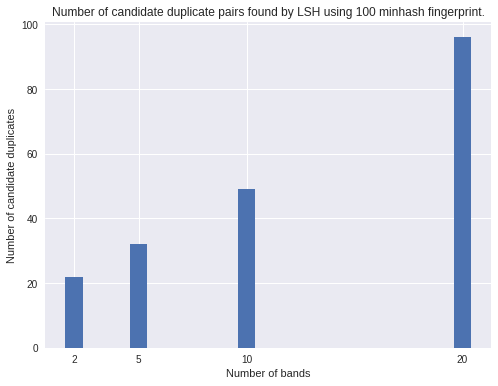

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(bands, num_candidates, align='center');
plt.title('Number of candidate duplicate pairs found by LSH using 100 minhash fingerprint.');
plt.xlabel('Number of bands');
plt.ylabel('Number of candidate duplicates');
plt.xticks(bands, bands);

So the more promiscuous [4] version (20 bands per fingerprint) finds many more candidate pairs than the conservative 2 bands model. The first implication of this difference is that it leads to you having to do more comparisons to find the real duplicates. Let's see what that looks like in practice.

We'll slightly modify the `candidate_duplicates` function so that it stores the line number along with the document ID, that way we can retrieve to document contents easier later on.

In [51]:
def candidate_duplicates(document_feed, char_ngram=5, seeds=100, bands=5, hashbytes=4):
    char_ngram = 5
    sims = []
    hasher = minhash.MinHasher(seeds=seeds, char_ngram=char_ngram, hashbytes=hashbytes)
    if seeds % bands != 0:
        raise ValueError('Seeds has to be a multiple of bands. {} % {} != 0'.format(seeds, bands))
    
    lshcache = cache.Cache(num_bands=bands, hasher=hasher)
    for i_line, line in enumerate(document_feed):
        line = line.decode('utf8')
        docid, headline_text = line.split('\t', 1)
        fingerprint = hasher.fingerprint(headline_text.encode('utf8'))
        
        # in addition to storing the fingerpring store the line
        # number and document ID to help analysis later on
        lshcache.add_fingerprint(fingerprint, doc_id=(i_line, docid))

    candidate_pairs = set()
    for b in lshcache.bins:
        for bucket_id in b:
            if len(b[bucket_id]) > 1:
                pairs_ = set(itertools.combinations(b[bucket_id], r=2))
                candidate_pairs.update(pairs_)
    
    return candidate_pairs

In [71]:
lines = []
with open('/usr/local/scratch/data/rcv1/headline.text.txt', 'rb') as fh:
    # read the first 1000 lines into memory so we can compare them
    for line in itertools.islice(fh, 1000):
        lines.append(line.decode('utf8'))
    
    # reset file pointer and do LSH
    fh.seek(0)
    feed = itertools.islice(fh, 1000)
    candidates = candidate_duplicates(feed, char_ngram=5, seeds=100, bands=20, hashbytes=4)

# go over all the generated candidates comparing their similarities
similarities = []
for ((line_a, docid_a), (line_b, docid_b)) in candidates:
    doc_a, doc_b = lines[line_a], lines[line_b]
    shingles_a = shingles(lines[line_a])
    shingles_b = shingles(lines[line_b])
    
    jaccard_sim = jaccard(shingles_a, shingles_b)
    fingerprint_a = set(hasher.fingerprint(doc_a.encode('utf8')))
    fingerprint_b = set(hasher.fingerprint(doc_b.encode('utf8')))
    minhash_sim = len(fingerprint_a & fingerprint_b) / len(fingerprint_a | fingerprint_b)
    similarities.append((docid_a, docid_b, jaccard_sim, minhash_sim))

In [72]:
import random

print('There are {} candidate duplicates in total'.format(len(candidates)))
random.sample(similarities, k=15)

There are 111 candidate duplicates in total


[('2317', '2293', 0.6090381426202321, 0.4492753623188406),
 ('2544', '2403', 0.8514745308310991, 0.7094017094017094),
 ('2742', '2387', 0.6901698404529079, 0.4925373134328358),
 ('2306', '2940', 0.4451428571428571, 0.26582278481012656),
 ('2506', '2507', 0.996265172735761, 1.0),
 ('2335', '2536', 0.8379651436646255, 0.7241379310344828),
 ('2361', '2315', 0.7490176817288802, 0.5748031496062992),
 ('2311', '2372', 0.7974055703929798, 0.7241379310344828),
 ('2302', '2971', 0.576, 0.5151515151515151),
 ('2910', '2857', 0.9893048128342246, 0.941747572815534),
 ('2336', '2338', 0.9870317002881844, 0.9801980198019802),
 ('2312', '2303', 0.6593059936908517, 0.45985401459854014),
 ('2486', '2875', 0.6749619095987811, 0.5037593984962406),
 ('2323', '2451', 0.7245482591449978, 0.5267175572519084),
 ('3256', '3186', 0.3084023668639053, 0.11731843575418995)]

So LSH with 20 bands indeed finds a lot of candidate duplicates (111 out of 1000), some of which - for instance (3256, 3186) above - are not all that similar. Let's see how many LSH missed given some similarity threshold.

In [73]:
sims_all = np.zeros((1000, 1000), dtype=np.float64)
for i, line in enumerate(lines):
    for j in range(i+1, len(lines)):
        shingles_a = shingles(lines[i])
        shingles_b = shingles(lines[j])
        jaccard_sim = jaccard(shingles_a, shingles_b)
        
        # similarities are symmetric so we only care about the
        # upper diagonal here and leave (j, i) to be 0
        sims_all[i, j] = jaccard_sim

In [74]:
# turn the candidates into a dictionary so we have easy access to
# candidates pairs that were found
candidates_dict = {(line_a, line_b): (docid_a, docid_b) for ((line_a, docid_a), (line_b, docid_b)) in candidates}
found = 0
for i in range(len(lines)):
    for j in range(i+1, len(lines)):
        if sims_all[i, j] >= .9:
            # documents i and j have an actual Jaccard similarity >= 90%
            found += ((i, j) in candidates_dict or (j, i) in candidates_dict)

print('Out of {} pairs with similarity >= 90% {} were found, that\'s {:.1%}'.format((sims_all >= .9).sum(), found, found / (sims_all >= .9).sum()))

Out of 27 pairs with similarity >= 90% 27 were found, that's 100.0%


That seems pretty well inline with the <a href="#bands_rows">figure</a> showing how setting bands and rows affects the probability of finding similar documents. So we're doing quite well in terms of the true positives, what about the false positives? 27 pairs of documents from the ones found were true positives, so the rest are false positives. Since LSH found 110 document pairs in total $110-27 = 83$ pairs were incorrect, that's 83 documents that were checked in vein in comparison to the 499000 pairs we would have had to go through for an all pairs comparison.

_499000 is the number of entries on the upper diagonal of a $1000\times1000$ matrix. Since document similarities are symmetric we only need to compare `i` to `j` not `j` to `i`, so that's $\frac{1000\times1000}{2}$. We also don't need compare `i` to `i` or `j` to `j` which cuts out the last 1000 entries on the diagonal._

# References

- [1] <cite>Reuters Corpora (RCV1, RCV2, TRC2)</cite> http://trec.nist.gov/data/reuters/reuters.html
- [2] <cite>Amazon product data</cite> http://jmcauley.ucsd.edu/data/amazon/
- [3] <cite>Mining Massive Datasets</cite> http://www.mmds.org http://infolab.stanford.edu/~ullman/mmds/ch3.pdf by `Leskovec, Rajamaran and Ullman`
- [4] <cite>promiscuous</cite> demonstrating or implying an unselective approach; indiscriminate or casual: _the city fathers were promiscuous with their honours._

In [93]:
# preprocess RCV1 to be contained in a single file
import glob, zipfile, re
import xml.etree.ElementTree as ET

files = glob.glob('../data/rcv1/xml/*.zip')
with open('../data/rcv1/headline.text.txt', 'wb') as out:
    for f in files:
        zf = zipfile.ZipFile(f)
        for zi in zf.namelist():
            fh = zf.open(zi, 'r')
            root = ET.fromstring(fh.read().decode('latin-1'))
            itemid = root.attrib['itemid']
            headline = root.find('./headline').text
            text = ' '.join(root.find('./text').itertext())
            text = re.sub('\s+', ' ', text)
            out.write(('{}\t{} {}\n'.format(itemid, headline, text)).encode('utf8'))